In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
import xgboost as xgb
from my_functions import map_home, numeric_houses, dummy_houses, quality_multiplication, test_col_matcher
# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Read in the labaled data

In [2]:
df = pd.read_csv('../datasets/train.csv')
df.columns =df.columns.str.lower().str.replace(' ','_')

#### Taking a peek at the missing values in two ways

80 Columns and the target (sale price). df['alley] is almost all missing and I sense there are different logical reasons for the rates of missing values. There may be no way to describe quality of an amenity that a house does not have! 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

Divide and conquer! I found that most columns

In [4]:
# Only the features missing data in order of most missing to least missing
features = list(df.columns)
missing_vals= [(df[features[i]].isna().mean(),features[i])for i in range(80) if df[features[i]].isna().mean() > 0]
missing_vals.sort(key=lambda pair: pair[0], reverse= True)
missing_vals[:10] 

[(0.9956118966357874, 'pool_qc'),
 (0.9683081423695759, 'misc_feature'),
 (0.931740614334471, 'alley'),
 (0.8049731838127743, 'fence'),
 (0.48756704046806437, 'fireplace_qu'),
 (0.16089712335446124, 'lot_frontage'),
 (0.05558264261335934, 'garage_yr_blt'),
 (0.05558264261335934, 'garage_finish'),
 (0.05558264261335934, 'garage_qual'),
 (0.05558264261335934, 'garage_cond')]

In [5]:
missing_num = len(missing_vals)
# round to 4 places
missing_vals = [(round(missing_vals[i][0],4),missing_vals[i][1]) for i in range(missing_num)] 
# what are the data types of the missing features lets put that in the list
missing_vals_types = [(missing_vals[i][0],missing_vals[i][1],df[missing_vals[i][1]].dtype) for i in range(missing_num)]
# spliting this list in two for the two types of missing data
missing_vals_numeric = [missing_vals_types[i] for i in range(missing_num) if missing_vals_types[i][2] != 'object']
missing_vals_object = [missing_vals_types[i] for i in range(missing_num) if missing_vals_types[i][2] == 'object']


In [6]:
missing_vals_numeric

[(0.1609, 'lot_frontage', dtype('float64')),
 (0.0556, 'garage_yr_blt', dtype('float64')),
 (0.0107, 'mas_vnr_area', dtype('float64')),
 (0.001, 'bsmt_full_bath', dtype('float64')),
 (0.001, 'bsmt_half_bath', dtype('float64')),
 (0.0005, 'bsmtfin_sf_1', dtype('float64')),
 (0.0005, 'bsmtfin_sf_2', dtype('float64')),
 (0.0005, 'bsmt_unf_sf', dtype('float64')),
 (0.0005, 'total_bsmt_sf', dtype('float64')),
 (0.0005, 'garage_cars', dtype('float64')),
 (0.0005, 'garage_area', dtype('float64'))]

In [7]:
missing_vals_object

[(0.9956, 'pool_qc', dtype('O')),
 (0.9683, 'misc_feature', dtype('O')),
 (0.9317, 'alley', dtype('O')),
 (0.805, 'fence', dtype('O')),
 (0.4876, 'fireplace_qu', dtype('O')),
 (0.0556, 'garage_finish', dtype('O')),
 (0.0556, 'garage_qual', dtype('O')),
 (0.0556, 'garage_cond', dtype('O')),
 (0.0551, 'garage_type', dtype('O')),
 (0.0283, 'bsmt_exposure', dtype('O')),
 (0.0273, 'bsmtfin_type_2', dtype('O')),
 (0.0268, 'bsmt_qual', dtype('O')),
 (0.0268, 'bsmt_cond', dtype('O')),
 (0.0268, 'bsmtfin_type_1', dtype('O')),
 (0.0107, 'mas_vnr_type', dtype('O'))]

What do these columns look like?

In [8]:
# lets look at the numeric data first
# dataframe of the numeric data columns
df_numeric = df[[missing_vals_numeric[i][1] for i in range(len(missing_vals_numeric))]]
df_numeric.describe()

,lot_frontage,garage_yr_blt,mas_vnr_area,bsmt_full_bath,bsmt_half_bath,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,garage_cars,garage_area
count,1721.000000,1937.000000,2029.000000,2049.000000,2049.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000
mean,69.055200,1978.707796,99.695909,0.427526,0.063446,442.300488,47.959024,567.728293,1057.987805,1.776585,473.671707
std,23.260653,25.441094,174.963129,0.522673,0.251705,461.204124,165.000901,444.954786,449.410704,0.764537,215.934561
min,21.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58.000000,1961.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.000000,793.000000,1.000000,319.000000
50%,68.000000,1980.000000,0.000000,0.000000,0.000000,368.000000,0.000000,474.500000,994.500000,2.000000,480.000000
75%,80.000000,2002.000000,161.000000,1.000000,0.000000,733.750000,0.000000,811.000000,1318.750000,2.000000,576.000000
max,313.000000,2207.000000,1600.000000,3.000000,2.000000,5644.000000,1474.000000,2336.000000,6110.000000,5.000000,1418.000000


In [9]:
# make notebook display all columns
pd.set_option('display.max_columns', None)

In [10]:
# what is going on with the garage year built
df[df['garage_yr_blt'] > 2010]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1699,2261,916384070,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,267300


In [11]:
# that should be 2007 not 2207
df[df['garage_yr_blt'] == 2207]['garage_yr_blt'] = 2007

In [12]:
# is something weird about the basements in iowa?
# basements more than 2 std dev from the mean
df[df['total_bsmt_sf'] > 2000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
30,380,527355150,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,PosN,Norm,1Fam,1Story,8,5,1981,1981,Hip,WdShngl,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,1104.0,Unf,0.0,1420.0,2524.0,GasA,TA,Y,SBrkr,2524,0,0,2524,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Gd,Attchd,1981.0,Fin,2.0,542.0,TA,TA,Y,474,120,0,0,0,0,NaN,MnPrv,NaN,0,7,2009,WD,278000
41,2383,528110050,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.0,Unf,0.0,690.0,2076.0,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.0,0.0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,850.0,TA,TA,Y,216,229,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,465000
81,367,527214050,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,1Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,748.0,Ex,TA,PConc,Ex,TA,No,GLQ,1904.0,Unf,0.0,312.0,2216.0,GasA,Ex,Y,SBrkr,2234,0,0,2234,1.0,0.0,2,0,1,1,Ex,9,Typ,1,Gd,Attchd,2009.0,Fin,3.0,1166.0,TA,TA,Y,0,60,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,501837
199,448,528166060,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,922.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,56.0,Unf,0.0,2336.0,2392.0,GasA,Ex,Y,SBrkr,2392,0,0,2392,0.0,0.0,2,0,3,1,Ex,8,Typ,1,Ex,Attchd,2003.0,Fin,3.0,968.0,TA,TA,Y,248,105,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,386250
222,2323,527146135,160,RL,68.0,13108,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,8,5,1994,1994,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,2062.0,2062.0,GasA,Ex,Y,SBrkr,2079,608,0,2687,0.0,0.0,2,1,4,1,Gd,9,Typ,0,NaN,Attchd,1994.0,Fin,2.0,618.0,TA,TA,Y,168,12,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,270000
286,960,916382100,20,RL,113.0,13438,Pave,NaN,IR1,HLS,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2008,2008,Gable,CompShg,CemntBd,CmentBd,Stone,246.0,Ex,TA,CBlock,Ex,TA,Gd,GLQ,1758.0,Unf,0.0,432.0,2190.0,GasA,Ex,Y,SBrkr,2036,0,0,2036,1.0,0.0,2,0,3,1,Ex,9,Typ,1,Ex,Attchd,2008.0,Fin,3.0,780.0,TA,TA,Y,90,154,0,0,0,0,NaN,NaN,NaN,0,7,2009,WD,410000
328,1773,528366050,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,8,5,1992,1993,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1231.0,Unf,0.0,1969.0,3200.0,GasA,Ex,Y,SBrkr,3228,0,0,3228,1.0,0.0,3,0,4,1,Gd,10,Typ,1,Gd,Attchd,1992.0,RFn,2.0,546.0,TA,TA,Y,264,75,291,0,0,0,NaN,NaN,NaN,0,5,2007,WD,430000
359,1106,528363110,20,RL,91.0,10437,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,8,6,1995,1995,Hip,CompShg,MetalSd,MetalSd,BrkFace,660.0,Gd,Gd,PConc,Gd,TA,Gd,GLQ,1696.0,Unf,0.0,413.0,2109.0,GasA,Ex,Y,SBrkr,2113,0,0,2113,1.0,0.0,2,1,2,1,Gd,7,Typ,1,TA,Attchd,1995.0,Fin,3.0,839.0,TA,TA,Y,236,46,0,0,0,0,NaN,NaN,NaN,0,8,2008,WD,350000
378,1614,526355170,20,RL,95.0,13651,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,6,1973,1973,Gable,CompShg,Plywood,Plywood,BrkFace,1115.0,TA,Gd,CBlock,Gd,TA,Gd,ALQ,1880.0,Unf,0.0,343.0,2223.0,GasA,Ex,Y,SBrkr,2223,0,0,2223,1.0,0.0,2,0,3,1,TA,

In [13]:
# are these housees that have basements or not? they seem to all match square foot with the first floor square foot
df[(df['total_bsmt_sf'] > 2000) & (df['total_bsmt_sf'] == df['1st_flr_sf'])]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
30,380,527355150,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,PosN,Norm,1Fam,1Story,8,5,1981,1981,Hip,WdShngl,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,1104.0,Unf,0.0,1420.0,2524.0,GasA,TA,Y,SBrkr,2524,0,0,2524,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Gd,Attchd,1981.0,Fin,2.0,542.0,TA,TA,Y,474,120,0,0,0,0,NaN,MnPrv,NaN,0,7,2009,WD,278000
41,2383,528110050,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.0,Unf,0.0,690.0,2076.0,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.0,0.0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,850.0,TA,TA,Y,216,229,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,465000
199,448,528166060,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,922.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,56.0,Unf,0.0,2336.0,2392.0,GasA,Ex,Y,SBrkr,2392,0,0,2392,0.0,0.0,2,0,3,1,Ex,8,Typ,1,Ex,Attchd,2003.0,Fin,3.0,968.0,TA,TA,Y,248,105,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,386250
378,1614,526355170,20,RL,95.0,13651,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,6,1973,1973,Gable,CompShg,Plywood,Plywood,BrkFace,1115.0,TA,Gd,CBlock,Gd,TA,Gd,ALQ,1880.0,Unf,0.0,343.0,2223.0,GasA,Ex,Y,SBrkr,2223,0,0,2223,1.0,0.0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1973.0,Fin,2.0,516.0,TA,TA,Y,300,0,0,0,0,0,NaN,NaN,NaN,0,2,2007,WD,244000
623,457,528176030,20,RL,100.0,14836,Pave,NaN,IR1,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2004,2005,Hip,CompShg,CemntBd,CmentBd,Stone,730.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2146.0,Unf,0.0,346.0,2492.0,GasA,Ex,Y,SBrkr,2492,0,0,2492,1.0,0.0,2,1,2,1,Ex,8,Typ,1,Ex,Attchd,2004.0,Fin,3.0,949.0,TA,TA,Y,226,235,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,552000
1117,1764,528327060,20,RL,NaN,11400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,10,5,2001,2002,Hip,CompShg,VinylSd,VinylSd,BrkFace,705.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1282.0,Unf,0.0,1351.0,2633.0,GasA,Ex,Y,SBrkr,2633,0,0,2633,1.0,0.0,2,1,2,1,Ex,8,Typ,2,Gd,Attchd,2001.0,RFn,3.0,804.0,TA,TA,Y,314,140,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,466500
1142,564,532478020,20,RL,NaN,15676,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,8,8,1980,1980,Gable,CompShg,VinylSd,VinylSd,BrkFace,115.0,Gd,Gd,CBlock,Gd,Gd,Gd,ALQ,1733.0,Rec,92.0,189.0,2014.0,GasA,Gd,Y,SBrkr,2014,0,0,2014,1.0,0.0,2,0,2,1,Gd,6,Maj1,2,Gd,Attchd,1980.0,RFn,3.0,864.0,TA,TA,Y,462,0,0,255,0,0,NaN,MnPrv,NaN,0,4,2009,WD,275000
1248,1615,526355190,20,RL,95.0,15865,Pave,NaN,IR1,Lvl,AllPub,Inside,Mod,NAmes,Norm,Norm,1Fam,1Story,8,6,1970,1970,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,PConc,TA,Gd,Gd,ALQ,351.0,Rec,823.0,1043.0,2217.0,GasA,Ex,Y,SBrkr,2217,0,0,2217,1.0,0.0,2,0,4,1,Gd,8,Typ,1,TA,Attchd,1970.0,Unf,2.0,621.0,TA,TA,Y,81,207,0,0,224,0,NaN,NaN,NaN,0,10,2007,WD,268000
1561,2100,906378150,20,RL,93.0,10481,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,2140.0,2140.0,GasA,Ex,Y,SBrkr,2140,0,0,2140,0.0,0.0,2,1

index 1885 led me down a rabbit hole of curiostiy. 

In [14]:
# distribution of the basement square foot and first floor square
# I literally think this house is a crime scene
# 908154195
df[df['pid'] == 908154195]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


In [15]:
# this house solde between median and mean sale price for this data set and it is enormous
df['saleprice'].mean(), df['saleprice'].median()


(181469.70160897123, 162500.0)

In [16]:
df[df['pid'] == 908154195][['saleprice', 'gr_liv_area','lot_area', 'garage_area', 'misc_feature', 'misc_val', 'sale_type']]


,saleprice,gr_liv_area,lot_area,garage_area,misc_feature,misc_val,sale_type
1885,183850,5095,39290,1154.0,Elev,17000,New


In [17]:
# ratios of the sale price, above ground square footage, lot area, garage area, misc value for their elevator compared to the medians
# side note in a 1-story home in Iowa - this house 
df[df['pid'] == 908154195][['saleprice', 'gr_liv_area', 'lot_area', 'garage_area', 'misc_val']]/df[df['sale_type'] == 'New'][['saleprice', 'gr_liv_area', 'lot_area', 'garage_area', 'misc_val']].mean()

,saleprice,gr_liv_area,lot_area,garage_area,misc_val
1885,0.658911,2.83396,3.555608,1.709994,160.0


In [18]:
# are there any other houses similar to this one? Enormmous new, good condition and paradoxically cheap? I am sure there is a reason but doubt it can be determined from the data we have
# houses with similar lot area and above ground square footage
df[(df['gr_liv_area'] > 4000) & (df['lot_area'] >5000)][['pid','saleprice', 'gr_liv_area', 'lot_area', 'garage_area', 'misc_val', 'sale_type']]

,pid,saleprice,gr_liv_area,lot_area,garage_area,misc_val,sale_type
960,908154235,160000,5642,63887,1418.0,0,New
1885,908154195,183850,5095,39290,1154.0,17000,New


In [19]:
# ratios with neighborhood median for the other absurdly cheap house?
df[df['pid'] == 908154235][['saleprice', 'gr_liv_area', 'lot_area', 'garage_area', 'misc_val']]/df[(df['neighborhood'] == 'Edwards') &(df['sale_type']=='New') ][['saleprice', 'gr_liv_area', 'lot_area', 'garage_area', 'misc_val']].mean()

,saleprice,gr_liv_area,lot_area,garage_area,misc_val
960,1.0018,1.744859,2.214684,1.608166,0.0


In [20]:
# drop them from the data set -908154235, 908154195
df = df[df['pid'] != 908154235]
df = df[df['pid'] != 908154195]

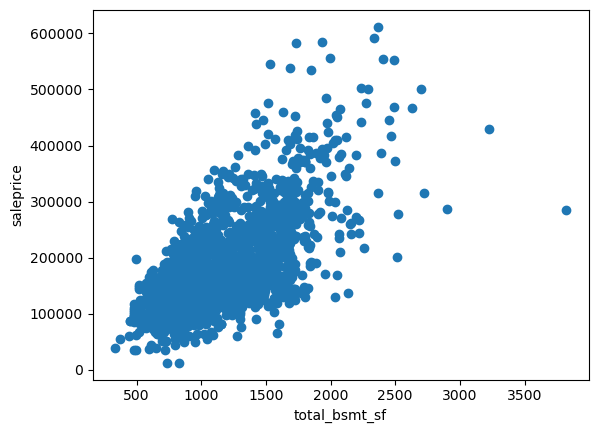

In [21]:
# plot sale price against square foot
plt.scatter(df['1st_flr_sf'], df['saleprice'])
plt.xlabel('total_bsmt_sf')
plt.ylabel('saleprice')
plt.show()


In [22]:
# most expensive houses here?
df[df['saleprice'] > 600000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1671,45,528150070,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188.0,Unf,0.0,142.0,2330.0,GasA,Ex,Y,SBrkr,2364,0,0,2364,1.0,0.0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3.0,820.0,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,611657


<Axes: >

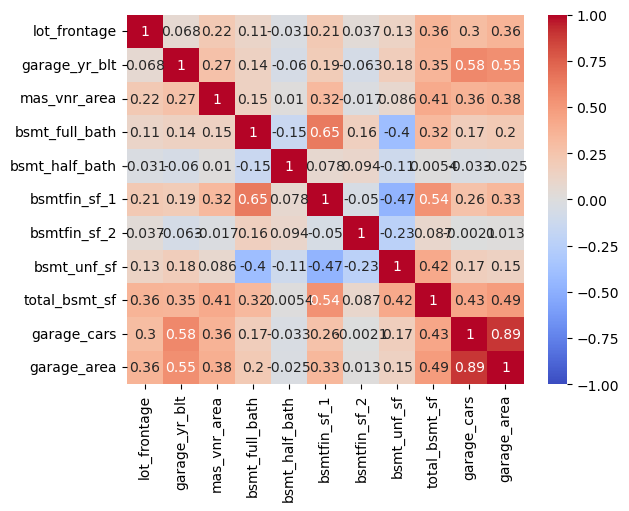

In [23]:
# correlation between numeric features - many of these may be just copied from each other and may not serve much purpose
# we will see what happens when we drop them
sns.heatmap(df_numeric.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1)

number of cars and garage area highest corr. interestingly year built and cars/area have high correlation - trends of larger garages visible

In [24]:
# lets look at the object data
# dataframe of the object data columns
df_object = df[[missing_vals_object[i][1] for i in range(len(missing_vals_object))]]
# show the value counts for each column
for i in range(len(df_object.columns)):
    print(df_object.columns[i])
    print(df_object[df_object.columns[i]].value_counts())
    print('\n')

pool_qc
Gd    3
Fa    2
TA    2
Ex    1
Name: pool_qc, dtype: int64


misc_feature
Shed    56
Gar2     4
Othr     3
TenC     1
Name: misc_feature, dtype: int64


alley
Grvl    85
Pave    55
Name: alley, dtype: int64


fence
MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: fence, dtype: int64


fireplace_qu
Gd    521
TA    407
Fa     59
Po     31
Ex     31
Name: fireplace_qu, dtype: int64


garage_finish
Unf    849
RFn    579
Fin    507
Name: garage_finish, dtype: int64


garage_qual
TA    1830
Fa      82
Gd      18
Ex       3
Po       2
Name: garage_qual, dtype: int64


garage_cond
TA    1866
Fa      47
Gd      12
Po       8
Ex       2
Name: garage_cond, dtype: int64


garage_type
Attchd     1211
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: garage_type, dtype: int64


bsmt_exposure
No    1339
Av     288
Gd     201
Mn     163
Name: bsmt_exposure, dtype: int64


bsmtfin_type_2
Unf    1747
Rec      80
LwQ      60
BLQ      48
ALQ      35
GL

In [25]:
# what about the columns without missing values? what do they look like? Are there any major issues with the data? Easy fixes?
# dataframe of the columns without missing values
df_no_missing = df.drop([missing_vals[i][1] for i in range(len(missing_vals))], axis=1)

In [26]:
# what are the columns that are not numeric? lets look at their value counts
# for each non numeric columns, value counts
for i in range(len(df_no_missing.columns)):
    if df_no_missing[df_no_missing.columns[i]].dtype == 'object':
        print(df_no_missing.columns[i])
        print(df_no_missing[df_no_missing.columns[i]].value_counts())
        print('\n')

ms_zoning
RL         1596
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64


street
Pave    2042
Grvl       7
Name: street, dtype: int64


lot_shape
Reg    1295
IR1     691
IR2      55
IR3       8
Name: lot_shape, dtype: int64


land_contour
Lvl    1843
HLS      85
Bnk      78
Low      43
Name: land_contour, dtype: int64


utilities
AllPub    2047
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64


lot_config
Inside     1502
Corner      347
CulDSac     131
FR2          60
FR3           9
Name: lot_config, dtype: int64


land_slope
Gtl    1951
Mod      88
Sev      10
Name: land_slope, dtype: int64


neighborhood
NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV  

utilities: NoSeWa, NoSewr only appear once each. They cannot be accounted for by the models. This should be safe to drop
electrical: mix 1 only - drop? Not for now

In [27]:
# anything else wierd about numeric columns without missings?
df_no_missing.describe()

,id,pid,ms_subclass,lot_area,overall_qual,overall_cond,year_built,year_remod/add,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
count,2049.000000,2.049000e+03,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.00000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,1473.676428,7.134001e+08,57.025378,10024.677892,6.108346,5.562714,1971.673499,1984.166423,1160.848219,329.18692,5.518302,1495.553441,1.576867,0.370425,2.843826,1.042948,6.428990,0.589068,93.554417,47.224500,22.593948,2.593948,16.527574,2.165935,43.327965,6.220595,2007.775988,181479.018058
std,844.248064,1.886859e+08,42.837269,6608.511749,1.421780,1.104897,30.171293,21.032785,379.066122,425.59571,51.093509,485.783577,0.549389,0.500901,0.826804,0.209888,1.544572,0.635842,128.195671,65.857797,59.870165,25.241801,57.399890,36.297124,434.481342,2.742380,1.312533,79295.913255
min,1.000000,5.263011e+08,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.00000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.000000,5.284581e+08,20.000000,7500.000000,5.000000,5.000000,1953.000000,1964.000000,879.000000,0.00000,0.000000,1128.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129800.000000
50%,1481.000000,5.354532e+08,50.000000,9405.000000,6.000000,5.000000,1974.000000,1993.000000,1092.000000,0.00000,0.000000,1444.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2199.000000,9.071760e+08,70.000000,11500.000000,7.000000,6.000000,2001.000000,2004.000000,1404.000000,691.00000,0.000000,1728.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,3820.000000,1862.00000,1064.000000,3820.000000,4.000000,2.000000,8.000000,3.000000,14.000000,4.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,12500.000000,12.000000,2010.000000,611657.000000


The dilema I have.

* Very little data (2000 points) with 80 columns, the better I make a model - even with a train test split - the worse it will be. Gaming the metrics in the iteration of model building will lead to a 'suprise' when the model proves useless. Even though the data is split and unseen by the 'model' it is not modeled in isolation. Positive feedback loops of increasing 'scores' or something - 
* Sales are subjective - I have basic amenities their qualities and nothing else. Examine the house above: New house $183850 with a $17,000 elevator in an area where the mean sale is $181469 and the median is $162500. $4,100 dollars over asking average sale price for this estate
* So many important features that have fewer than 5 occurances many have fewer than 2 occurances

The object variables seems to have a few systems of coding and I manage those in my map_home() function. Missings for these objects are either coded as a 0 (quality and condition) or kept as n/a for categorical variables until on-hot-encoding

# Project Challenges

One major challenge in this project is that there are 26 columns that are missing data with a wide variety of causes. Data-coding issue? Amenity missing? Bad data entry? 

## Handling Missing Values

If a house does not have a specific amenity, the other columns describing its quality and condition might be null or zero. Missing values in numeric columns will likely be imputed to zero. Categorical can be 

## Model Objective

The goal is to build a model that will not lose any information about the amenities or their condition.

Many variables seem to be on an ordinal scale like this

In [28]:
df['fireplace_qu'].value_counts()

Gd    521
TA    407
Fa     59
Po     31
Ex     31
Name: fireplace_qu, dtype: int64

80 columns and the target,saleprice, Lots of data missing and different types. Lots  of cleaning to do.

<p>One major challenge in this project is that there are many columns that are missing for a significant number of houses.</p> 
<p>If it does not have the specific amenity the other columns describing its quality and condition - will they be null? zero?. </p> <p> I want to build a model that will not lose any information about the amenities or their condition.</p>

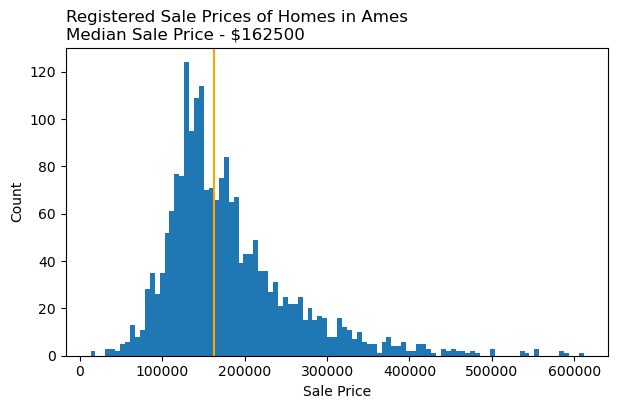

In [29]:
plt.figure(figsize=(7,4))
plt.hist(df['saleprice'], bins = 100)
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.axvline(np.median(df['saleprice']), color='orange')
plt.title('Registered Sale Prices of Homes in Ames \n'+ 
          'Median Sale Price - $162500',loc= 'left')
plt.savefig('../images/price_hist.png');

In [30]:
df.corr()['saleprice'].sort_values(ascending=False).head(20)

saleprice         1.000000
overall_qual      0.803462
gr_liv_area       0.719463
total_bsmt_sf     0.664819
garage_area       0.655483
garage_cars       0.648667
1st_flr_sf        0.648252
year_built        0.572405
year_remod/add    0.550872
full_bath         0.538225
garage_yr_blt     0.534514
mas_vnr_area      0.520023
totrms_abvgrd     0.509775
fireplaces        0.473783
bsmtfin_sf_1      0.445764
lot_frontage      0.355530
open_porch_sf     0.338545
wood_deck_sf      0.327629
lot_area          0.303744
bsmt_full_bath    0.284763
Name: saleprice, dtype: float64

In [31]:
# is there a column that has like grlivearea but is not grlivearea?
# if so what is the name
df.columns[df.columns.str.contains('gr_liv')]

Index(['gr_liv_area'], dtype='object')

In [32]:
df.corr()['overall_qual'].sort_values(ascending=False).head(20)

overall_qual      1.000000
saleprice         0.803462
year_built        0.602376
garage_cars       0.587417
year_remod/add    0.584080
garage_yr_blt     0.573909
gr_liv_area       0.564933
garage_area       0.559804
total_bsmt_sf     0.552397
full_bath         0.515052
1st_flr_sf        0.474783
mas_vnr_area      0.432345
fireplaces        0.384147
totrms_abvgrd     0.375268
open_porch_sf     0.300504
bsmt_unf_sf       0.275625
half_bath         0.272717
bsmtfin_sf_1      0.266829
wood_deck_sf      0.252890
2nd_flr_sf        0.228222
Name: overall_qual, dtype: float64

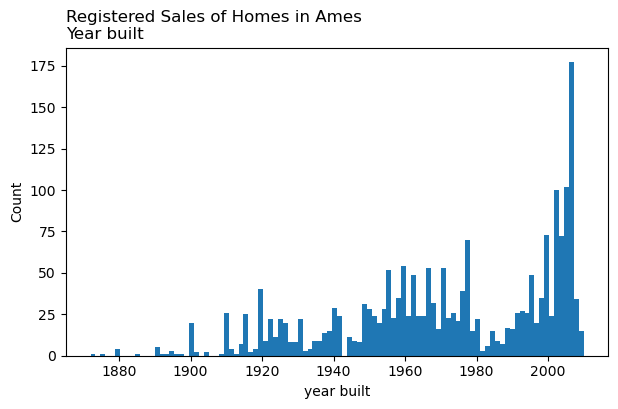

In [33]:
plt.figure(figsize=(7,4))
plt.hist(df['year_built'], bins = 100)
plt.xlabel('year built')
plt.ylabel('Count')
# plt.axvline(np.mean(df['year_built']), color='orange')
plt.title('Registered Sales of Homes in Ames \n'+ 
           'Year built',loc= 'left')
plt.savefig('../images/year_built_hist.png');

Oversupply of new houses near spiked just around 2008 - thats unfortunate and may explain the sale prices of the giants - they are forclosures that would cost too much too upkeep 

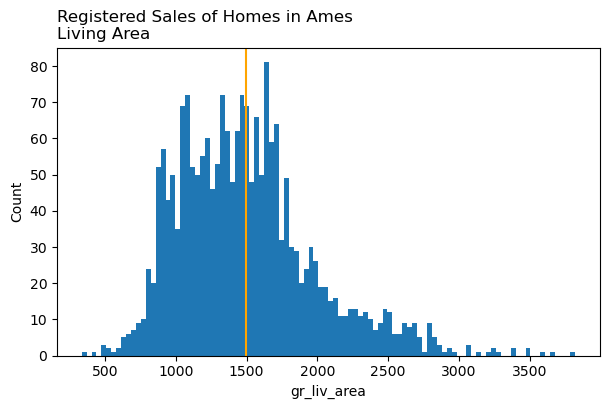

In [34]:
plt.figure(figsize=(7,4))
plt.hist(df['gr_liv_area'], bins = 100)
plt.xlabel('gr_liv_area')
plt.ylabel('Count')
plt.axvline(np.mean(df['gr_liv_area']), color='orange')
plt.title('Registered Sales of Homes in Ames \n'+ 
           'Living Area',loc= 'left')
plt.savefig('../images/gr_liv_area_hist.png');

#### Next, I will map, clean missing data, make dummy columns, and prepare for feature engineering 
In map_home()map the 'quality' columns to make them ordinal, which is then used to add a quality multiplier to the various types of amenities described in the data. A simple reason for why is this: A garage should increase your house's value if it is in good condition. If it is in disrepair it is a burden and its presence should decrease the sale price. This and other valuation of amenity problems are addressed in the functions I created for this


In numeric_houses() I clean the missing values from numeric columns.


In dummy_houses() I one-hot-encode the categorical variables to create columns that indicate the presence or absence of specific amenities of the property (misc_feature_Shed or misc_feature_TenC for example)


In [35]:
# lets make a function to clean the data
def clean_data(df):
    df1 = map_home(df)
    df2 = numeric_houses(df1)
    df3 = dummy_houses(df2)
    df_multplied = quality_multiplication(df3)
    return df_multplied

In [36]:
df_multplied = clean_data(df)

In [37]:
# train test split
X = df_multplied.drop('saleprice', axis=1)
y = df_multplied['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1536, 327), (513, 327), (1536,), (513,))

Parameters were from gridsearching earlier - I am concerned what hyper parameter tuning does for over fitting the model but will see how this goes from here

In [39]:
gb_params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}
xgb_params = {'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 300,
 'subsample': 0.9}
rf_params = {'n_estimators': 300,}

In [40]:
# I need the models and parameters to use this
def train_models(models, X_train, y_train):
    trained_models = []
    for model in models:
        model_instance = model
        model_instance.fit(X_train, y_train)
        trained_models.append(model_instance)
    return trained_models

def aggregate_predictions(models, X):
    preds_all = pd.DataFrame()
    for model in models:
        preds = model.predict(X)
        preds_model = pd.DataFrame(preds, columns=[str(model).split('(')[0]+'_preds'])
        preds_all = pd.concat([preds_all, preds_model], axis=1)
    return preds_all

def create_error_dataframe(models, X_train, y_train, X_test, y_test):
    metrics_dict = {
        'Model': [],
        'RMSLE_train': [],
        'RMSLE': [],
        'RMSE_train': [],
        'RMSE': [],
        'MAE_train': [],
        'MAE': []
    }
    for model in models:
        model_name = str(model).split('(')[0]
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
        test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        metrics_dict['Model'].append(model_name)
        metrics_dict['RMSLE'].append(test_rmsle)
        metrics_dict['RMSE'].append(test_rmse)
        metrics_dict['MAE'].append(test_mae)
        metrics_dict['RMSLE_train'].append(train_rmsle)
        metrics_dict['RMSE_train'].append(train_rmse)
        metrics_dict['MAE_train'].append(train_mae)
        
    
    error_df = pd.DataFrame(metrics_dict)
    error_df.set_index('Model', inplace=True)
    return error_df

In [41]:
# make model list
models = [RandomForestRegressor(**rf_params), GradientBoostingRegressor(**gb_params), xgb.XGBRegressor(**xgb_params)]
# train models
trained_models = train_models(models, X_train, y_train)
# make predictions
preds_all = aggregate_predictions(trained_models, X_test)
# create error dataframe
error_df = create_error_dataframe(trained_models, X_train, y_train, X_test, y_test)

In [42]:
error_df

,RMSLE_train,RMSLE,RMSE_train,RMSE,MAE_train,MAE
Model,,,,,,
RandomForestRegressor,0.063492,0.139815,9101.830828,27480.285882,5876.245535,16172.920622
GradientBoostingRegressor,0.049796,0.126123,6324.785636,24302.463737,4972.122468,14604.374993
XGBRegressor,0.049563,0.121706,6197.515710,22696.555399,4705.878967,13777.492523


In [43]:
# how much did my quality multiplication help? Lets compare this to the same models without the quality multiplication
# df was 

In [44]:
# clean data 
# lets make a function to clean the data but without the quality multiplication
def clean_data_simpler(df):
    df1 = map_home(df)
    df2 = numeric_houses(df1)
    df3 = dummy_houses(df2)
    return df3

In [45]:
# clean data the df data frame is the original data frame with the same drops and fixes but before my other stps
# I am intentionally leaving out the quality multiplication step to compare the effect of that step to its absence
df_simpler = clean_data_simpler(df)

In [46]:
# train test split
X = df_simpler.drop('saleprice', axis=1)
y = df_simpler['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)

In [47]:
# make model list
models = [RandomForestRegressor(**rf_params), GradientBoostingRegressor(**gb_params), xgb.XGBRegressor(**xgb_params)]
# train models
trained_models_without = train_models(models, X_train, y_train)
# make predictions
preds_all_without = aggregate_predictions(trained_models_without, X_test)
# create error dataframe
error_df_without = create_error_dataframe(trained_models_without, X_train, y_train, X_test, y_test)


In [48]:
error_df_without

,RMSLE_train,RMSLE,RMSE_train,RMSE,MAE_train,MAE
Model,,,,,,
RandomForestRegressor,0.062448,0.140138,9082.650326,27488.826562,5928.660857,16163.213616
GradientBoostingRegressor,0.045069,0.126903,6015.344727,24264.728111,4736.318438,14599.586450
XGBRegressor,0.046428,0.124663,5942.473948,22795.657581,4490.070833,14106.729144


### soft voting regressor

In [52]:
# I want to train and fit a voting regresor with all of the models in my imports
# I need to make a list of the models and their parameters
models = [RandomForestRegressor(**rf_params), GradientBoostingRegressor(**gb_params), xgb.XGBRegressor(**xgb_params), DecisionTreeRegressor()]
# Define individual regressors
reg1 = RandomForestRegressor(**rf_params)
reg2 = GradientBoostingRegressor(**gb_params)
reg3 = xgb.XGBRegressor(**xgb_params)
# Define a voting regressor
voting_regressor = VotingRegressor([('rf', reg1), ('gb', reg2), ('xgb', reg3)])
# don't forget to train test split the engineered data
X = df_multplied.drop('saleprice', axis=1)
y = df_multplied['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)
# Train the ensemble regressor on the training data
voting_regressor.fit(X_train, y_train)
# Evaluate MSE, RMSE, MAE
y_pred = voting_regressor.predict(X_test)
print("RMSLE of voting regressor: ", np.sqrt(mean_squared_log_error(y_test, y_pred)))
print("RMSE of voting regressor: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE of voting regressor: ", mean_absolute_error(y_test, y_pred))

RMSLE of voting regressor:  0.12422954295505312
RMSE of voting regressor:  23906.06082371161
MAE of voting regressor:  14261.485799352251


In [53]:
# how does this voting regressor do on train data?
y_pred_train = voting_regressor.predict(X_train)
print("RMSLE of voting regressor: ", np.sqrt(mean_squared_log_error(y_train, y_pred_train)))
print("RMSE of voting regressor: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("MAE of voting regressor: ", mean_absolute_error(y_train, y_pred_train))

RMSLE of voting regressor:  0.050686498735107895
RMSE of voting regressor:  6417.247278033297
MAE of voting regressor:  4902.383755889606


I honestly am not sure which would work better - the voting regressor is has higher training scores (less over-fit) than my xgb model while keeping the testing scores low. The voting regressor may do better on unseen data.

In [56]:
# generate predictions for the test data
test = pd.read_csv('../datasets/test.csv')
test.columns =test.columns.str.lower().str.replace(' ','_')


In [57]:
test_multplied = clean_data(test)
test_resized = test_col_matcher(X_train, test_multplied)

In [61]:
# make predictions
test_preds = voting_regressor.predict(test_resized)
# turn into dataframe
submission = pd.DataFrame({'Id': test['id'], 'SalePrice': test_preds})
submission.head()

,Id,SalePrice
0,2658,144916.577254
1,2718,142882.547890
2,2414,197095.594076
3,1989,111268.202326
4,625,173945.157686


In [62]:
# save to csv
submission.to_csv('../datasets/submission.csv', index=False)